## HAADF and EELS only
- Haadf
- sample 20 locations - get eels
- pca plots of eels on the haadf

In [ ]:
from stemOrchestrator.logging_config import setup_logging

data_folder = "."
out_path = data_folder
setup_logging(out_path=out_path)

In [ ]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging
import Pyro5.api

plot = plt
from typing import Dict

In [ ]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if ip is None:
    print("please check path of yaml file containing ip and port info")

else:
    print("your yaml file with ip and port loaded fine")
config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 40e-8,  # micro-seconds per pixel
    "haadf_resolution": 512,  # square
    "out_path": ".",
}

In [ ]:
ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]


microscope = TemMicroscopeClient()
microscope.connect(ip, port=port)  # 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope, offline=False)
uri = "PYRO:array.server@10.46.217.242:9094"
array_server = Pyro5.api.Proxy(uri)
dm_acquisition = DMacquisition(array_server, offline=False)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])

In [ ]:
# get haadf from mic

# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

In [ ]:
# best haadf after normalization
haadf_normalized = haadf

plt.imshow(haadf_normalized)

In [ ]:
# finds positions to sample from
import numpy as np
N = 20
rng = np.random.default_rng(42)
xs = rng.integers(0, W, size=N)
ys = rng.integers(0, H, size=N)
pixel_pos = np.stack([xs, ys], axis=1)

In [ ]:
# plot position sampled
plt.imshow(haadf_normalized)
plt.scatter(xs, ys, s=50, c="r")

In [ ]:
# ## acquire eels spectrum
# def acquire_and_plot_eels(
#     image_data: np.ndarray,
#     point_idx: int,
#     x: float,
#     y: float,
#     eels_exposure: float,
#     eels_offset: float,
#     out_path: str,
#     tf_acquisition,
#     dm_acquisition,
# ):
#     print(
#         f"\n>> Acquiring EELS at normalized position: ({x}, {y}) for point {point_idx}"
#     )

#     directory = os.path.join(out_path, f"manual_point_{point_idx}")
#     os.makedirs(directory, exist_ok=True)

#     # Move and acquire at centroid
#     tf_acquisition.move_paused_beam(x, y)
#     tf_acquisition.unblank_beam()
#     dm_acquisition.acquire_camera(exposure=eels_exposure)
#     tf_acquisition.blank_beam()

#     array_list, shape, dtype = dm_acquisition.get_eels()
#     spec_eels = np.array(array_list, dtype=dtype).reshape(shape)

#     # Query beam position
#     position = tf_acquisition.query_paused_beam_positon()
#     x_actual = position.x
#     y_actual = position.y
#     formatted_position = f"({x_actual:.2g}, {y_actual:.2g})"

#     # Plot image + spectrum
#     fig, axs = plt.subplots(1, 2, figsize=(18, 6))
#     axs[0].imshow(image_data, cmap="gray")
#     axs[0].set_title("HAADF with EELS Position")
#     axs[0].scatter(
#         x * image_data.shape[1],
#         y * image_data.shape[0],
#         c="r",
#         s=100,
#         marker="x",
#         label=f"Position: {formatted_position}",
#     )
#     axs[0].axis("off")

#     axs[1].plot(np.arange(len(spec_eels)) - eels_offset, spec_eels)
#     axs[1].set_title("EELS Spectrum")
#     axs[1].set_xlabel("Energy loss (eV)")
#     axs[1].set_ylabel("Counts")

#     plt.tight_layout()
#     fig.savefig(os.path.join(directory, f"haadf_eels_point_{point_idx}.png"), dpi=300)
#     plt.close()

#     np.save(os.path.join(directory, f"eels_spectrum_point_{point_idx}.npy"), spec_eels)

#     # Save metadata
#     metadata = {
#         "normalized_position": [x, y],
#         "beam_position": [x_actual, y_actual],
#         "exposure_time": eels_exposure,
#     }
#     with open(os.path.join(directory, "metadata.json"), "w") as f:
#         json.dump(metadata, f, indent=2)

#     print(f"Saved EELS spectrum and image overlay for point {point_idx}")

In [ ]:
# get edx at those positon and stack them
edx_exposure = 1  # in seconds
eels_exposure = 0.005
all_arrays = []  # 1. Create an empty list before the loop
for point in pixel_pos:
    # convert to fractional coordinates
    x_pos = point[0] / W
    y_pos = point[1] / H

    # position beam
    tf_acquisition.move_paused_beam(x_pos, y_pos)

    # Acquire the EDS spectrum
    microscope.optics.blanker.unblank()
    spectrum = dm_acquisition.get_eels()
    microscope.optics.blanker.blank()


    spectrum_data = spectrum
    #######----> need to create energy axis but lets do later

    # stack the arrays
    all_arrays.append(spectrum_data)  # 2. Add the new array to the list

spectra = np.stack(all_arrays, axis=0)
print(spectra.shape)

In [ ]:
# normalize the spectra
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps

In [ ]:
# pca the data
# import libraries

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

In [ ]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=scores[:, 0], s=50)
plt.title("HAADF + EELS PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EELS Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()

## Handling spectrum - beyond pca

In [ ]:
plt.plot(spectra.mean(axis = 1))

In [ ]:
plt.plot(spectra_norm.mean(axis = 1))

In [ ]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=spectra_norm.mean(axis = 1), s=50)
plt.title("HAADF + EELS Mean of spectrum")
plt.colorbar(label="mean of each spectrum", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
offset = 0
dispersion = 0.3  # eV/channel

mean_spec = spectra.mean(axis=0)
std_spec = spectra.std(axis=0)
energy_axis = dispersion * np.arange(len(mean_spec)) + offset

plt.figure(figsize=(10, 5))
plt.plot(energy_axis, mean_spec, label="Mean Spectrum", color='blue')
plt.fill_between(energy_axis, mean_spec - std_spec, mean_spec + std_spec,
                 color='blue', alpha=0.3, label="±1 Std. Dev.")
plt.xlabel("Energy Loss (eV)")
plt.ylabel("Intensity (a.u.)")
plt.title("Mean EELS Spectrum ± Std Dev")
plt.legend()
plt.grid(alpha=0.3)


In [ ]:
import numpy as np

def get_total_Au_counts_eels(energy_axis, spectrum_data, window=5):
    """
    Integrate total counts around Au EELS edges.

    Parameters
    ----------
    energy_axis : np.ndarray
        Energy loss values in eV.
    spectrum_data : np.ndarray
        EELS intensity array of same length as energy_axis.
    window : float, optional
        Half-width of integration range around each Au edge (in eV).

    Returns
    -------
    total_counts : float
        Sum of counts around all Au edges.
    """
    # Approximate EELS edges for Au (in eV)
    au_edges = [173, 2206, 2291]

    total_counts = 0.0
    for edge in au_edges:
        mask = (energy_axis >= edge - window) & (energy_axis <= edge + window)
        total_counts += spectrum_data[mask].sum()

    return total_counts


In [ ]:
# assuming `spectra` shape = (20, 512)
# and you already have energy_axis of length 512

au_counts_all = []

for i in range(spectra.shape[0]):
    spectrum_data = spectra[i]
    total_Au = get_total_Au_counts_eels(energy_axis, spectrum_data)
    au_counts_all.append(total_Au)

au_counts_all = np.array(au_counts_all)
print("Total Au counts for each spectrum:\n", au_counts_all)
print("Mean Au counts:", au_counts_all.mean())
print("Std dev:", au_counts_all.std())


## SAM-EELS

In [1]:
from stemOrchestrator.logging_config import setup_logging
import os

data_folder = "out-eels-1/"

os.makedirs(data_folder, exist_ok=True)
out_path = data_folder
setup_logging(out_path=out_path)

In [9]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging
import Pyro5.api

plot = plt
from typing import Dict

In [13]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if ip is None:
    print("please check path of yaml file containing ip and port info")

else:
    print("your yaml file with ip and port loaded fine")
config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 5e-6,  # micro-seconds per pixel
    "haadf_resolution": 512,  # square
    "out_path": f"{data_folder}",
}

your yaml file with ip and port loaded fine


In [14]:
ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]


microscope = TemMicroscopeClient()
microscope.connect(ip, port=port)  # 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope, offline=False)
uri = "PYRO:array.server@10.46.217.242:9094"
array_server = Pyro5.api.Proxy(uri)
dm_acquisition = DMacquisition(array_server, offline=False)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-11-03 14:07:49,763 - INFO - Starting microscope initialization...
2025-11-03 14:07:49,773 - INFO - CETA camera initialized
2025-11-03 14:07:49,777 - INFO - HAADF detector initialized
2025-11-03 14:07:49,784 - INFO - Microscope initialization completed successfully
2025-11-03 14:07:49,785 - INFO - initializing Microscope
2025-11-03 14:07:49,785 - INFO - activating camera
2025-11-03 14:07:53,974 - INFO - Microscope initialized with dummy DigiScan acquisition


2025-11-03 14:07:53,983 - INFO - Acquiring HAADF image.
2025-11-03 14:07:53,984 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-11-03 14:07:54,099 - INFO - DONE -- beam UNblanking
2025-11-03 14:07:56,199 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-11-03 14:07:56,214 - INFO - DONE -- beam blanking
2025-11-03 14:07:56,230 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-11-03 14:07:56,230 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


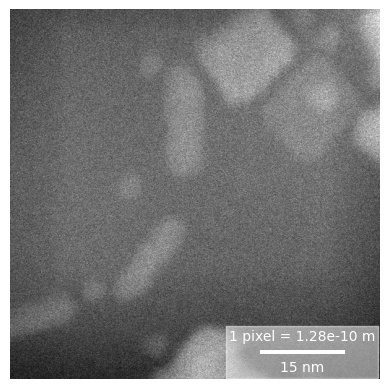

In [15]:
# get haadf from mic

# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution, folder_path=out_path
)

HAADF_tiff_to_png(out_path + haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

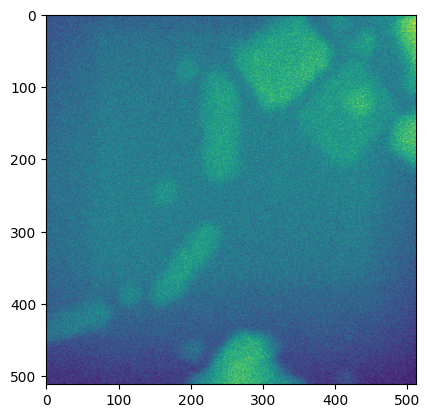

In [16]:
# best haadf after normalization
haadf_normalized = haadf_np_array

plt.imshow(haadf_normalized)

In [17]:
## get positons from sam

########SAM part ********************************************************************************************************
# -----> takes quite some time- 3 minutes-- to load --
from stemOrchestrator.MLlayer.MLlayerSAM import (
    setup_device,
    download_sam_model,
    initialize_sam_model,
    preprocess_image,
    generate_and_save_masks,
    create_normalized_particle_positions,
    display_image_with_masks,
    display_image_with_labels,
    extract_mask_contours,
    generate_mask_colors,
    visualize_masks_with_boundaries,
    extract_particle_data,
    print_boundary_points_info,
    plot_centroids,
    sample_particle_positions,
    plot_sampled_positions,
    create_visualization_with_masks,
)
import pickle
import numpy as np
from typing import List, Dict, Union


def run_sam(image_data: np.ndarray, path_folder: str) -> Union[List, Dict]:
    """Main function to run SAM segmentation pipeline."""
    device = setup_device()

    model_type = "vit_b"  # Options: 'vit_b', 'vit_l', 'vit_h'
    checkpoint_url = (
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    )
    checkpoint_path = "sam_vit_b_01ec64.pth"
    download_sam_model(model_type, checkpoint_url, checkpoint_path)
    sam, mask_generator = initialize_sam_model(model_type, checkpoint_path, device)
    img_np = preprocess_image(image_data)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Generate and visualize masks
    masks_path = f"{path_folder}/masks_Au_online.pkl"
    masks = generate_and_save_masks(mask_generator, img_np, masks_path)
    visual_image, centroids = create_visualization_with_masks(img_np, masks)
    display_image_with_masks(visual_image, "Image with Segmentation Masks")
    display_image_with_labels(
        visual_image, centroids, "Image with Segmentation Masks and Labels"
    )

    mask_contours = extract_mask_contours(masks)
    mask_colors = generate_mask_colors(len(masks))
    boundaries_path = (
        f"{path_folder}/Segmentation Masks with Boundaries and Centroids.png"
    )
    visualize_masks_with_boundaries(
        visual_image, centroids, mask_contours, mask_colors, boundaries_path
    )
    particles = extract_particle_data(masks)
    # Save particle data
    # with open(f'{path_folder}/particles.pkl', 'wb') as f:
    #     pickle.dump(particles, f)

    print_boundary_points_info(particles)
    centroids_array = np.array(centroids)
    plot_centroids(centroids_array, img_np)
    positions_sampled = sample_particle_positions(particles, img_np)
    plot_sampled_positions(positions_sampled, img_np, len(centroids))
    each_particle_position = create_normalized_particle_positions(
        particles, img_np.shape[:2]
    )
    # with open(f'{path_folder}/sampled_boundary_pts_particles.pkl', 'wb') as f: # Save normalized particle positions
    #     pickle.dump(each_particle_position, f)

    all_particle_keys = each_particle_position.keys()

    print("Processing complete!")
    return all_particle_keys, each_particle_position


##########****************************************************************************************************************************

20251103_140802
Using device: cuda
SAM model checkpoint already exists.


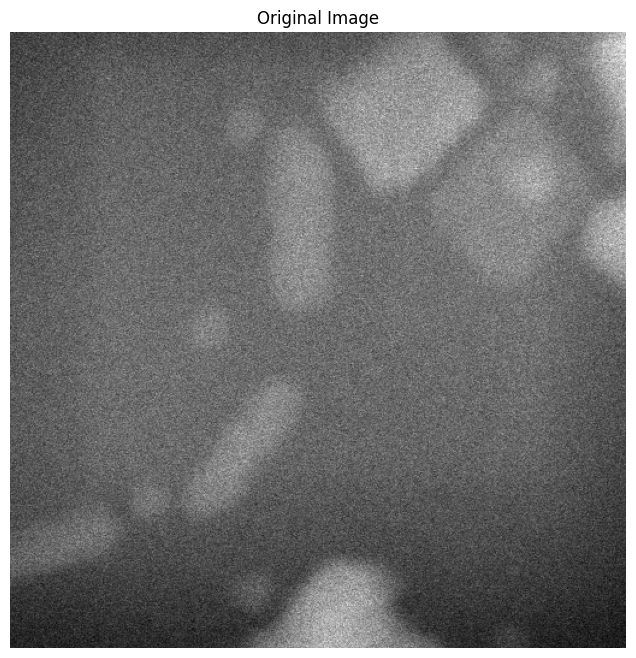

Generating masks...
Number of masks generated: 7
2025-11-03 14:08:21,418 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..154.6353].


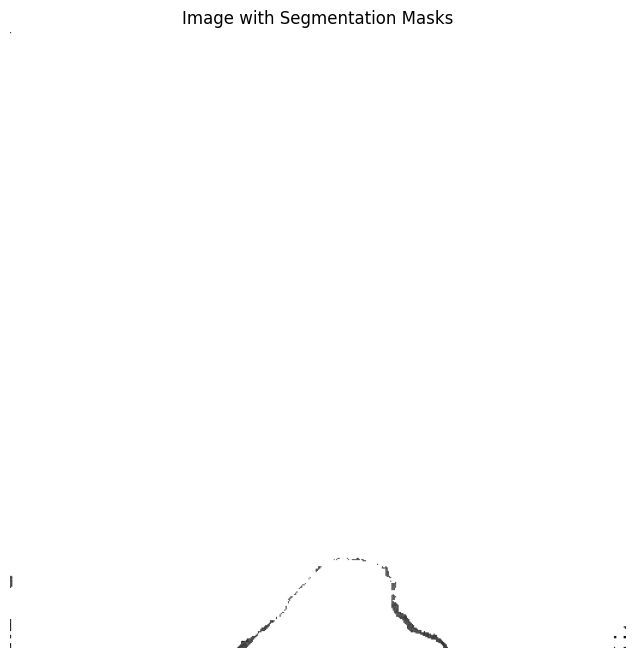

2025-11-03 14:08:21,508 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..154.6353].


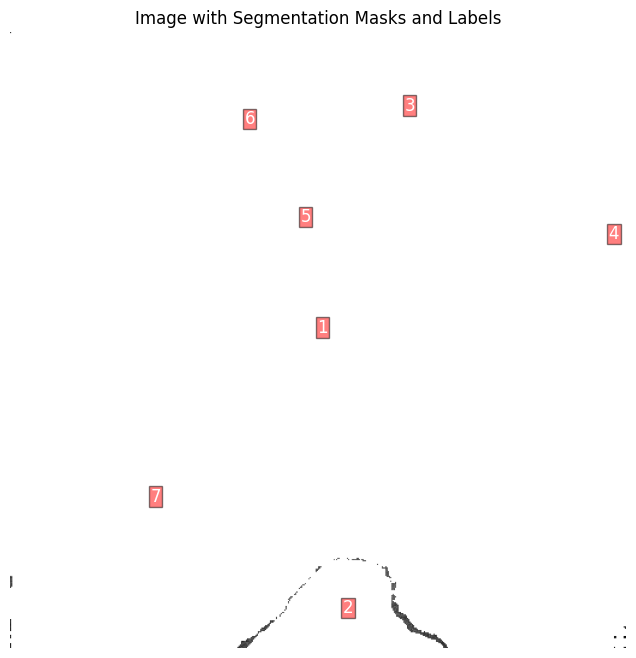

Extracted contours for 7 masks.
2025-11-03 14:08:21,623 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..154.6353].
Total particles stored: 7
Boundary Points per Particle:
-----------------------------
Particle 1: 7 boundary points
Particle 2: 8 boundary points
Particle 3: 8 boundary points
Particle 4: 6 boundary points
Particle 5: 10 boundary points
Particle 6: 10 boundary points
Particle 7: 9 boundary points
-----------------------------
Total boundary points across all particles: 58


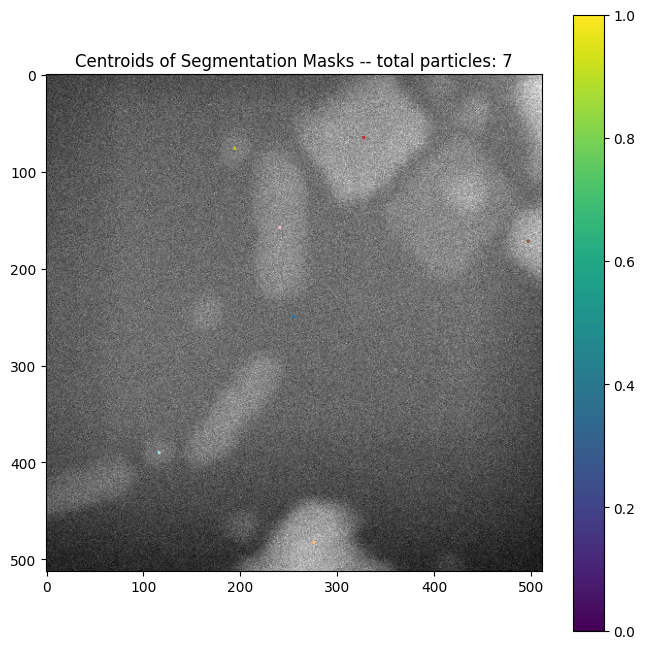

Positions array shape: (65, 3)


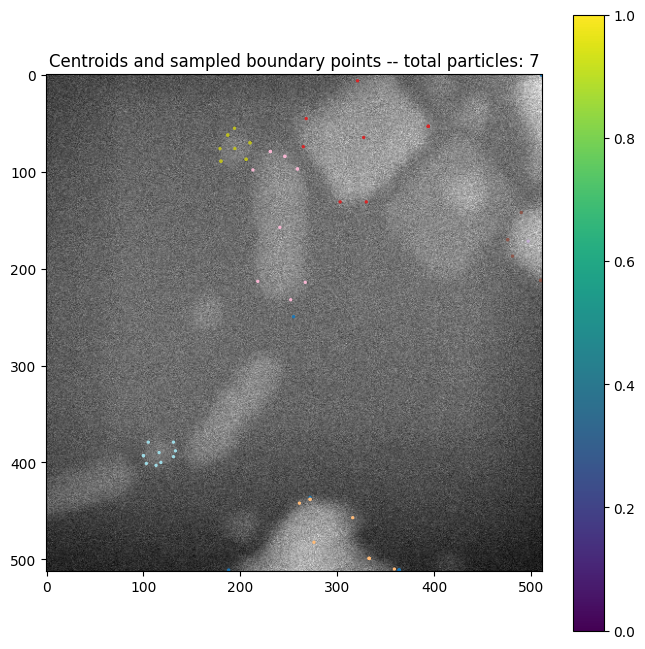

Processing complete!
20251103_140822


In [18]:
## run the segmentaiotn on haadf to get particles
from datetime import datetime

print(datetime.now().strftime("%Y%m%d_%H%M%S"))
all_particle_keys, each_particle_position = run_sam(
    haadf_np_array, out_path
)  ############ haadf normalized doesnt work here --- weird
print(datetime.now().strftime("%Y%m%d_%H%M%S"))

In [19]:
# finds positions to sample from
# N = 20
rng = np.random.default_rng(42)
# xs = rng.integers(0, W, size=N)
# ys = rng.integers(0, H, size=N)
# pixel_pos = np.stack([xs, ys], axis=1)

centroids = np.array([v["centroid"] for v in each_particle_position.values()])

# Sample N random centroids (without replacement if fewer than N)
N = len(centroids)
rng = np.random.default_rng(42)
idx = rng.choice(len(centroids), size=min(N, len(centroids)), replace=False)
sampled = centroids[idx]

# Separate xs and ys (keeping same data types as your original code)
xs = sampled[:, 0] * W
ys = sampled[:, 1] * H
pixel_pos = np.stack([xs, ys], axis=1)

print("xs:", xs)
print("ys:", ys)
print("pixel_pos:\n", pixel_pos)

np.save(f"{out_path}pixel_pos.npy", pixel_pos)

xs: [497.09884332 327.32177994 194.35911017 116.11577424 275.98684016
 240.81465457 254.94873562]
ys: [171.50262881  64.48795018  75.90783898 389.76121563 482.36463108
 157.30802512 249.46638295]
pixel_pos:
 [[497.09884332 171.50262881]
 [327.32177994  64.48795018]
 [194.35911017  75.90783898]
 [116.11577424 389.76121563]
 [275.98684016 482.36463108]
 [240.81465457 157.30802512]
 [254.94873562 249.46638295]]


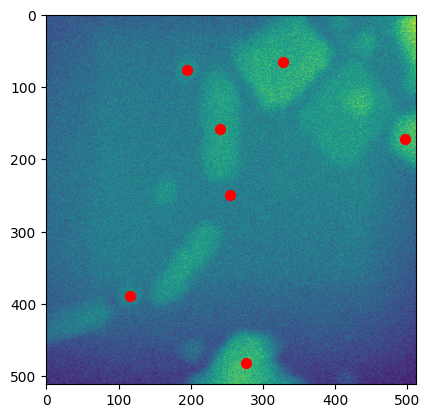

In [20]:
# plot position sampled
plt.imshow(haadf_normalized)
plt.scatter(xs, ys, s=50, c="r")
# want to save this? - nope

In [21]:
# get edx at those positon and stack them
edx_exposure = 1  # in seconds
eels_exposure = 0.005
all_arrays = []  # 1. Create an empty list before the loop
for point in pixel_pos:
    # convert to fractional coordinates
    x_pos = point[0] / W
    y_pos = point[1] / H

    # position beam
    tf_acquisition.move_paused_beam(x_pos, y_pos)

    # Acquire the EDS spectrum
    microscope.optics.blanker.unblank()
    spectrum = dm_acquisition.get_eels()
    microscope.optics.blanker.blank()


    spectrum_data = spectrum
    #######----> need to create energy axis but lets do later

    # stack the arrays
    all_arrays.append(spectrum_data)  # 2. Add the new array to the list

spectra = np.stack(all_arrays, axis=0)
print(spectra.shape)

2025-11-03 14:08:43,248 - INFO - Set beam position: old Point(x=1.125, y=-0.013941194)
2025-11-03 14:08:43,266 - INFO - UPDATED beam position: NewPoint(x=0.97089618, y=0.33496606)
2025-11-03 14:08:43,382 - INFO - Performing EELS
2025-11-03 14:08:46,214 - INFO - DONE EELS
2025-11-03 14:08:46,231 - INFO - Set beam position: old Point(x=0.97089618, y=0.33496606)
2025-11-03 14:08:46,250 - INFO - UPDATED beam position: NewPoint(x=0.63930035, y=0.12595303)
2025-11-03 14:08:46,365 - INFO - Performing EELS
2025-11-03 14:08:48,638 - INFO - DONE EELS
2025-11-03 14:08:48,654 - INFO - Set beam position: old Point(x=0.63930035, y=0.12595303)
2025-11-03 14:08:48,672 - INFO - UPDATED beam position: NewPoint(x=0.37960765, y=0.14825749)
2025-11-03 14:08:48,787 - INFO - Performing EELS
2025-11-03 14:08:51,066 - INFO - DONE EELS
2025-11-03 14:08:51,103 - INFO - Set beam position: old Point(x=0.37960765, y=0.14825749)
2025-11-03 14:08:51,120 - INFO - UPDATED beam position: NewPoint(x=0.22678863, y=0.76125

In [22]:

# normalize the spectra
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps

# save raw spectra
np.save(f"{out_path}raw_spectra.npy", spectra)
np.save(f"{out_path}normalized_spectra.npy",spectra_norm)

In [23]:
# pca the data
# import libraries

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

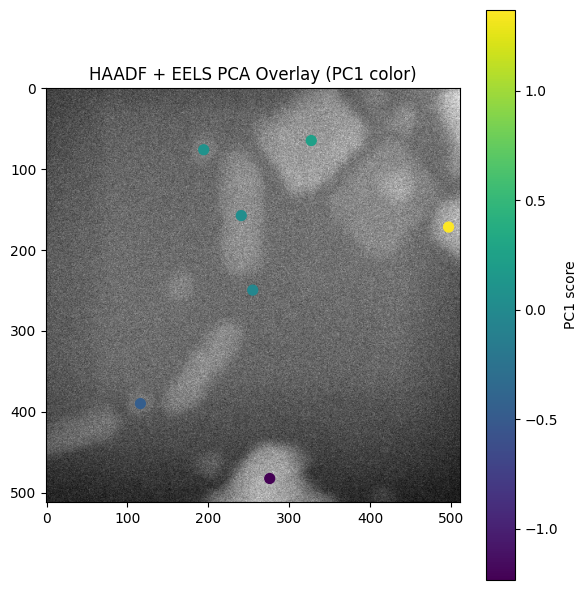

In [24]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=scores[:, 0], s=50)
plt.title("HAADF + EELS PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EELS Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()